Here, we are going to do dipole fits - as this is quite heavy processing you can use **8 CPUs**  
We are doing it on the *somato* dataset, but you have all the ingredients to apply it to your own data

In [11]:
#%% PACKAGES

import mne
from os.path import join
from os import chdir
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib widget


In [12]:
#%% SET DEFAULT PLOTTING PARAMETERS

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 3
plt.ion()

This data was added to UCloud

In [13]:
#somato_path = '/work/MEG_data/MNE-somato-data'
somato_path = '/home/lau/mne_data/MNE-somato-data'
somato_meg_path = join(somato_path, 'sub-01', 'meg')
subjects_dir = join(somato_path, 'derivatives', 'freesurfer', 'subjects')
subject = 'somato'
chdir(somato_meg_path)

# dataset with 111 somatosensory stimulations of the left hand
# https://mne.tools/stable/overview/datasets_index.html#somatosensory

Just get a quick and dirty evoked response

Opening raw data file /home/lau/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Finding events on: STI 014
111 events found on stim channel STI 014
Event IDs: [1]
Not setting metadata
111 matching events found
Setting baseline interval to [-0.19979521315838786, -0.01] s
Applying baseline correction (mode: mean)
0 projection items activated


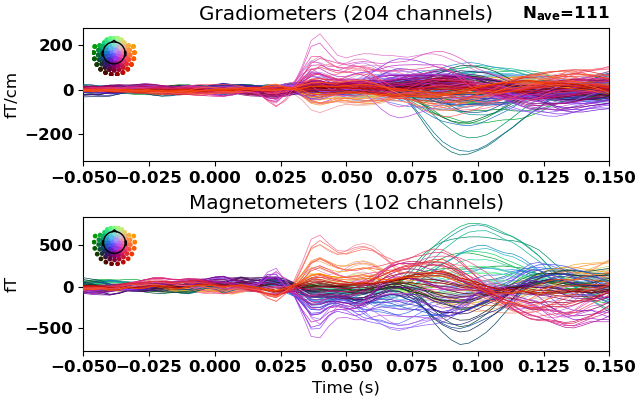

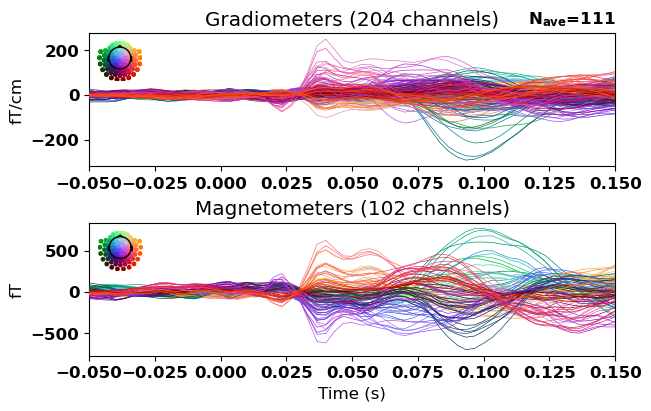

In [14]:
#%% GET EVOKED RESPONSE

raw_somato = mne.io.read_raw(join(somato_meg_path,
                                  'sub-01_task-somato_meg.fif'))

events_somato = mne.find_events(raw_somato)

event_id = dict(somato=1) # a somatosensory stimulation
tmin = -0.200 # s
tmax =  0.600 # s
baseline = (None, -0.010)

epochs_somato = mne.Epochs(raw_somato, events_somato, event_id, tmin, tmax,
                           baseline)

evoked_somato = epochs_somato.average()
evoked_somato.plot(xlim=(-0.050, 0.150))

Define the bem model needed for calculation of the lead field

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is   0.15 -21.35  32.94 mm
Surfaces passed the basic topology checks.
Complete.

Using surface: /home/lau/mne_data/MNE-somato-data/derivatives/freesurfer/subjects/somato/bem/inner_skull.surf
Using surface: /home/lau/mne_data/MNE-somato-data/derivatives/freesurfer/subjects/somato/bem/outer_skull.surf
Using surface: /home/lau/mne_data/MNE-somato-data/derivatives/freesurfer/subjects/somato/bem/outer_skin.surf


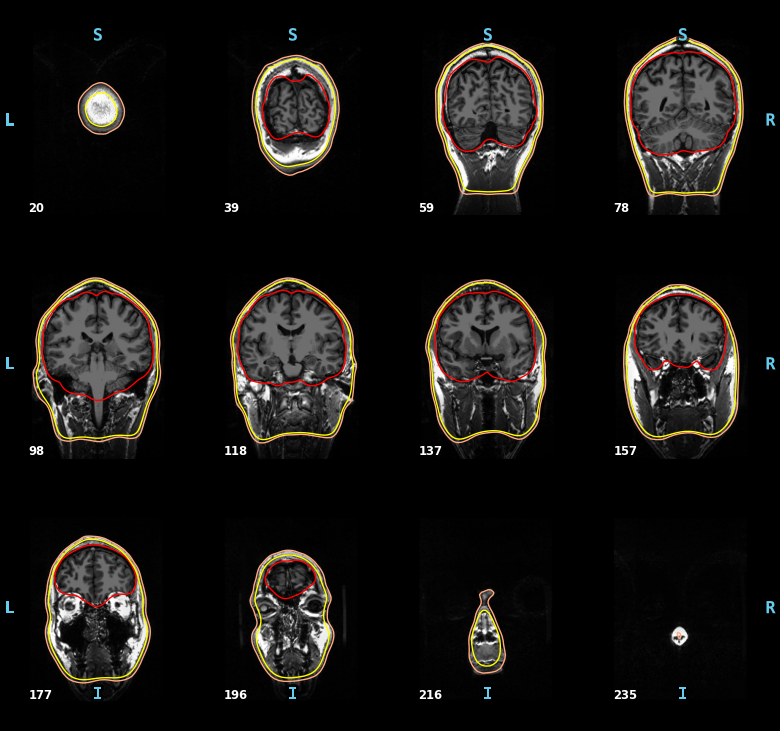

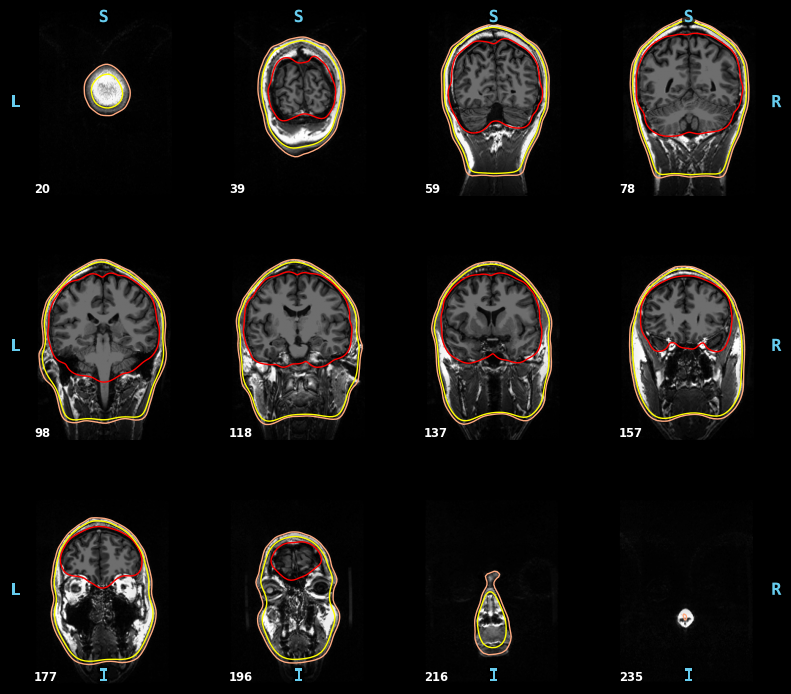

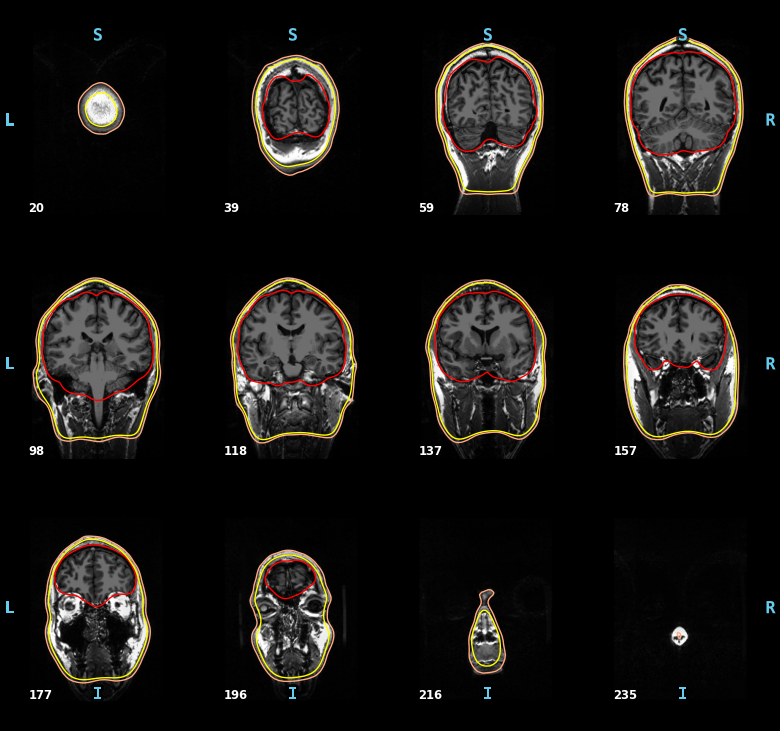

In [15]:
#%% DIPOLE FITTING

## boundary element method

## describe the surfaces and their conductivies
bem_model = mne.bem.make_bem_model(subject='01', subjects_dir=subjects_dir,
                                   conductivity=[0.3]) ## single layer model
## plot the three surfaces
mne.viz.plot_bem(subject, subjects_dir)


Load the pre-defined solution, or create it yourself (you have to uncomment; took about 2½ minutes with 8 CPUs)

In [16]:

## model how the currents spread throughout the brain
#bem_solution = mne.bem.make_bem_solution(bem_model)

bem_solution = mne.bem.read_bem_solution(join(subjects_dir, 'somato', 'bem', '01-5120-bem-sol.fif'))

## trans 
trans = join(somato_path, 'derivatives', 'sub-01', 'somato-trans.fif')


Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear collocation BEM solution from /home/lau/mne_data/MNE-somato-data/derivatives/freesurfer/subjects/somato/bem/01-5120-bem-sol.fif


Whitening the data from the magnetometers and the gradiometers based on the baseline period
Note that the real rank of the data doesn't correspond to the nominal rank

Loading data for 111 events and 241 original time points ...
0 bad epochs dropped
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 64
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 6438
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 102 dim * 7.4  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 204 dim * 45  max singular value)
    Estimated rank (grad): 64
    GRAD: rank 64 computed from 204 data channels with 0 projectors


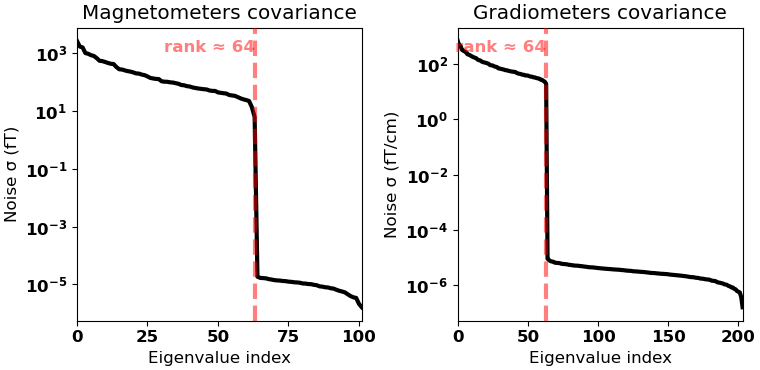

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

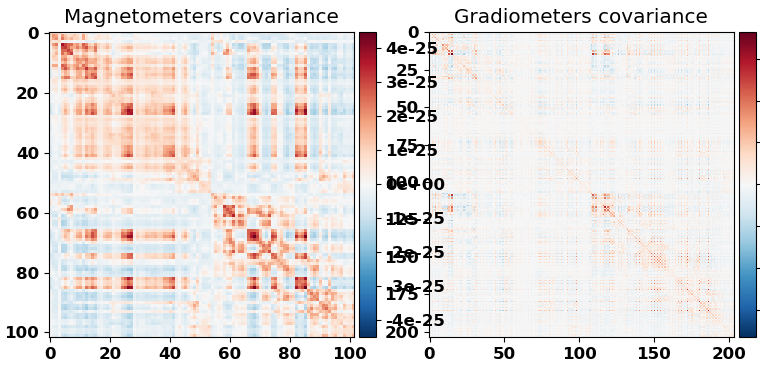

In [17]:

## noise_covariance - needed for whitening the channels, i.e. normalizing
# the output of the magnetometers and the gradiometers such that they are
# comparable

noise_cov_somato = mne.compute_covariance(epochs_somato, tmin=None, tmax=-0.010,
                                          rank='info')
noise_cov_somato.plot(epochs_somato.info)

Cropping the data - we don't wanna fit it all, i.e. we think dipoles are best for the early, sensory responses

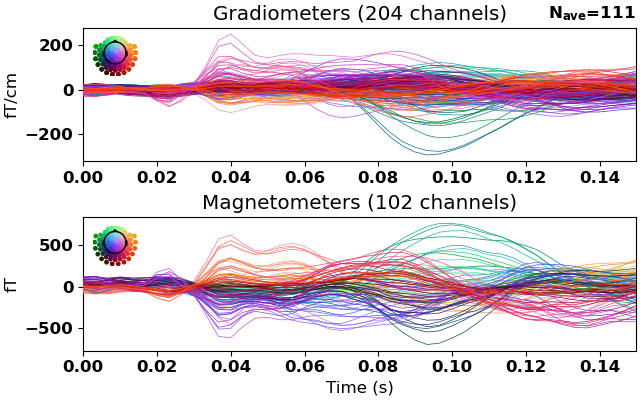

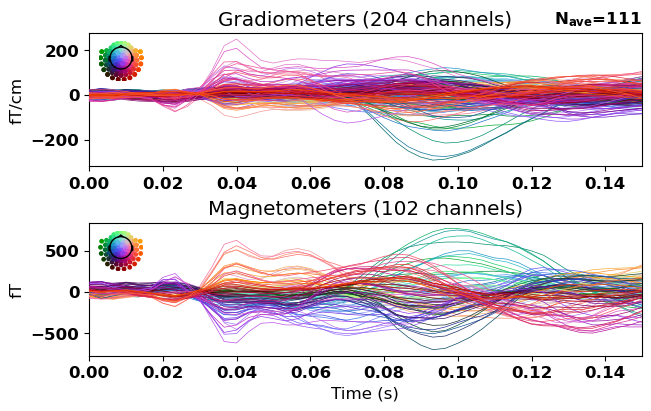

In [18]:
## dipole modelling

evoked_somato_cropped = evoked_somato.copy() ## create a copy to be cropped
evoked_somato_cropped.crop(0.000, 0.150) ## only look at this time interval

evoked_somato_cropped.plot()


The lead field and the source model are computed on the fly based on the bem solution.

In [19]:

## dipole fit - a forward model (lead field) and a (volumetric) source model
## are computed on the fly 
 
dip, residual = mne.dipole.fit_dipole(evoked_somato_cropped, noise_cov_somato,
                                      bem=bem_solution, trans=trans,
                                      n_jobs=-1)

BEM               : <ConductorModel | BEM (1 layer) solver=mne>
MRI transform     : /home/lau/mne_data/MNE-somato-data/derivatives/sub-01/somato-trans.fif
Head origin       :    1.7   13.6   55.5 mm rad =   78.2 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | kind : full, shape : (306, 306), range : [-1.4e-22, +3.6e-22], n_samples : 6437>

Coordinate transformation: MRI (surface RAS) -> head
    0.998557 0.034341 0.041291       0.91 mm
    -0.044994 0.954723 0.294074      23.61 mm
    -0.029322 -0.295507 0.954890      18.44 mm
    0.000000 0.000000 0.000000       1.00
Coordinate transformation: MEG device -> head
    0.997640 -0.061033 -0.031446       3.42 mm
    0.063766 0.993449 0.094829       6.64 mm
    0.025452 -0.096610 0.994997      54.42 mm
    0.000000 0.000000 0.000000       1.00
0 bad channels total
Read 306 MEG channels from info
105 coil definitions read
Coord

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   16.3s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   16.7s remaining:   10.0s


    Found  11/199 points outside using solid angles
    Total 250/482 points inside the surface
Interior check completed in 17050.6 ms
    232 source space points omitted because they are outside the inner skull surface.
    42 source space points omitted because of the    5.0-mm distance limit.
208 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Go through all guess source locations...


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[done 208 sources]


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


---- Fitted :     3.3 ms, distance to inner skull : 24.0924 mm
---- Fitted :    13.3 ms, distance to inner skull : 4.9924 mm
---- Fitted :     6.7 ms, distance to inner skull : 11.3568 mm
---- Fitted :    16.6 ms, distance to inner skull : 21.8845 mm
---- Fitted :    20.0 ms, distance to inner skull : 18.6722 mm
---- Fitted :    10.0 ms, distance to inner skull : 6.8346 mm
---- Fitted :    30.0 ms, distance to inner skull : 4.9756 mm
---- Fitted :     0.0 ms, distance to inner skull : 20.1472 mm
---- Fitted :    23.3 ms, distance to inner skull : 10.6882 mm
---- Fitted :    26.6 ms, distance to inner skull : 4.9760 mm


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s


---- Fitted :    36.6 ms, distance to inner skull : 15.3537 mm
---- Fitted :    33.3 ms, distance to inner skull : 13.0983 mm
---- Fitted :    40.0 ms, distance to inner skull : 14.8895 mm
---- Fitted :    56.6 ms, distance to inner skull : 18.9668 mm
---- Fitted :    46.6 ms, distance to inner skull : 8.6663 mm
---- Fitted :    43.3 ms, distance to inner skull : 12.3642 mm
---- Fitted :    49.9 ms, distance to inner skull : 8.6808 mm
---- Fitted :    59.9 ms, distance to inner skull : 20.7829 mm
---- Fitted :    63.3 ms, distance to inner skull : 10.8541 mm
---- Fitted :    53.3 ms, distance to inner skull : 13.1350 mm
---- Fitted :    66.6 ms, distance to inner skull : 12.0933 mm
---- Fitted :    69.9 ms, distance to inner skull : 11.6030 mm
---- Fitted :    73.3 ms, distance to inner skull : 10.1373 mm
---- Fitted :    79.9 ms, distance to inner skull : 5.6312 mm
---- Fitted :    86.6 ms, distance to inner skull : 4.9807 mm
---- Fitted :    76.6 ms, distance to inner skull : 7.7289 

[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   25.0s finished


Plotting different metrics for evaluating the dipole fit

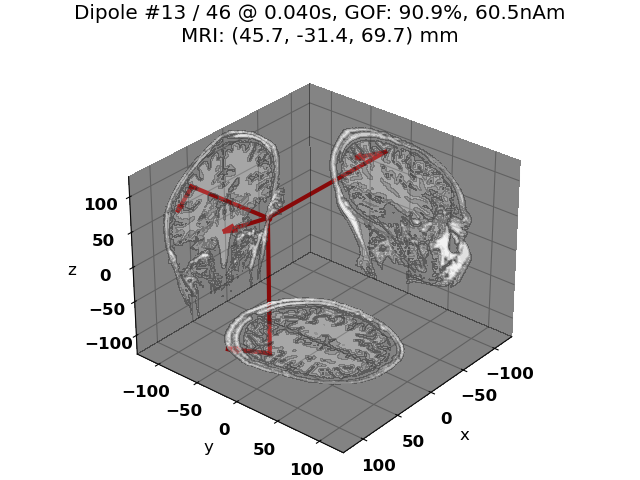

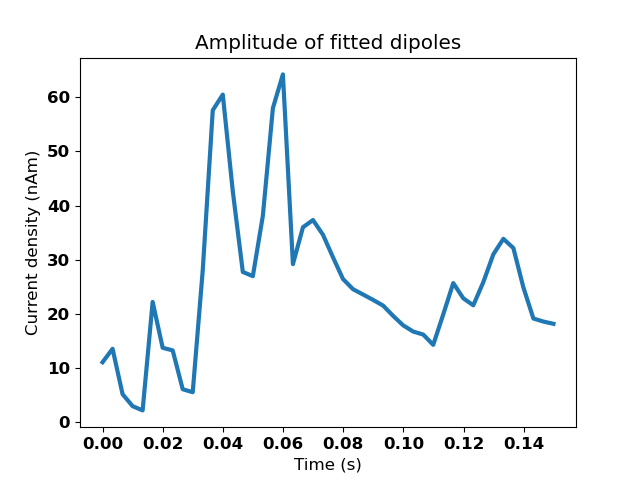

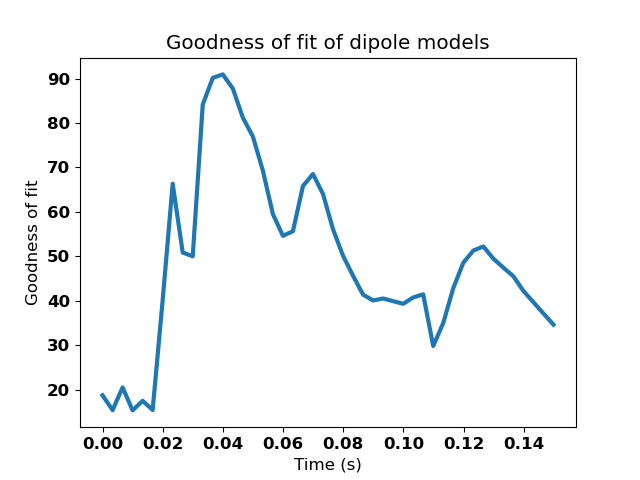

In [26]:
dip.plot_locations(trans=trans, subject=subject, subjects_dir=subjects_dir,
                   show_all=False) # show the dipole with the best fit
fig = plt.figure()
plt.plot(dip.times, dip.gof)
plt.title('Goodness of fit of dipole models')
plt.xlabel('Time (s)'); plt.ylabel('Goodness of fit') # 100 is max 0 is min

fig = plt.figure()
plt.plot(dip.times, dip.amplitude * 1e9)
plt.title('Amplitude of fitted dipoles')
plt.xlabel('Time (s)'); plt.ylabel('Current density (nAm)')
plt.show()

Doing a sequential fit, i.e. fitting a new dipole model on the residuals of the first fit:  
  - first fit, minimise: $fit_0 = (\boldsymbol b(t) - \hat{\boldsymbol b}(t)_{fit_0})^2$
  - second fit, minimise: $fit_1 =[(\boldsymbol{b}(t)- \hat{\boldsymbol b}(t)_{fit_0}) - \hat{\boldsymbol b}(t)_{fit_1}]^2$
  - ... and so on, *ad nauseam*

BEM               : <ConductorModel | BEM (1 layer) solver=mne>
MRI transform     : /home/lau/mne_data/MNE-somato-data/derivatives/sub-01/somato-trans.fif
Head origin       :    1.7   13.6   55.5 mm rad =   78.2 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | kind : full, shape : (306, 306), range : [-1.4e-22, +3.6e-22], n_samples : 6437>

Coordinate transformation: MRI (surface RAS) -> head
    0.998557 0.034341 0.041291       0.91 mm
    -0.044994 0.954723 0.294074      23.61 mm
    -0.029322 -0.295507 0.954890      18.44 mm
    0.000000 0.000000 0.000000       1.00
Coordinate transformation: MEG device -> head
    0.997640 -0.061033 -0.031446       3.42 mm
    0.063766 0.993449 0.094829       6.64 mm
    0.025452 -0.096610 0.994997      54.42 mm
    0.000000 0.000000 0.000000       1.00
0 bad channels total
Read 306 MEG channels from info
105 coil definitions read
Coord

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


[done 208 sources]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


---- Fitted :     3.3 ms, distance to inner skull : 5.7655 mm
---- Fitted :    10.0 ms, distance to inner skull : 8.4338 mm
---- Fitted :    16.6 ms, distance to inner skull : 4.8642 mm
---- Fitted :    20.0 ms, distance to inner skull : 27.9559 mm
---- Fitted :     6.7 ms, distance to inner skull : 6.9960 mm
---- Fitted :     0.0 ms, distance to inner skull : 16.1437 mm
---- Fitted :    13.3 ms, distance to inner skull : 17.2362 mm
---- Fitted :    23.3 ms, distance to inner skull : 26.7571 mm
---- Fitted :    26.6 ms, distance to inner skull : 23.6820 mm
---- Fitted :    40.0 ms, distance to inner skull : 6.2381 mm
---- Fitted :    36.6 ms, distance to inner skull : 8.9099 mm


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s


---- Fitted :    43.3 ms, distance to inner skull : 6.1436 mm
---- Fitted :    30.0 ms, distance to inner skull : 4.9755 mm
---- Fitted :    46.6 ms, distance to inner skull : 10.1623 mm
---- Fitted :    33.3 ms, distance to inner skull : 5.9501 mm
---- Fitted :    53.3 ms, distance to inner skull : 6.0890 mm
---- Fitted :    59.9 ms, distance to inner skull : 4.8760 mm
---- Fitted :    56.6 ms, distance to inner skull : 4.9521 mm
---- Fitted :    66.6 ms, distance to inner skull : 13.0410 mm
---- Fitted :    73.3 ms, distance to inner skull : 4.9757 mm
---- Fitted :    63.3 ms, distance to inner skull : 14.6609 mm
---- Fitted :    49.9 ms, distance to inner skull : 4.9892 mm
---- Fitted :    76.6 ms, distance to inner skull : 9.2471 mm
---- Fitted :    83.2 ms, distance to inner skull : 31.6343 mm
---- Fitted :    79.9 ms, distance to inner skull : 12.1101 mm
---- Fitted :    89.9 ms, distance to inner skull : 16.5974 mm
---- Fitted :    69.9 ms, distance to inner skull : 7.4963 mm
--

[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   19.6s finished


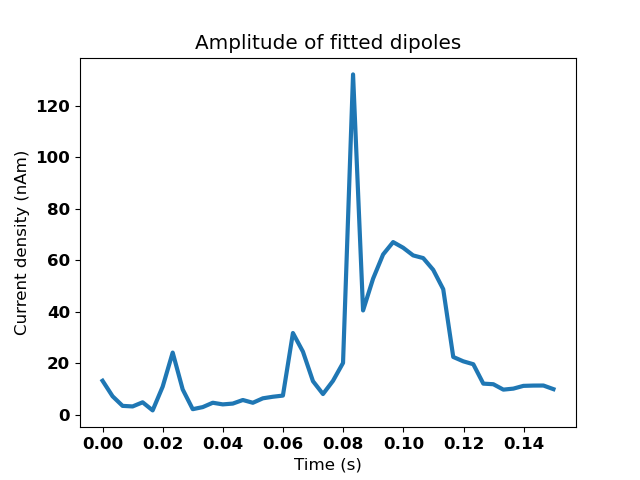

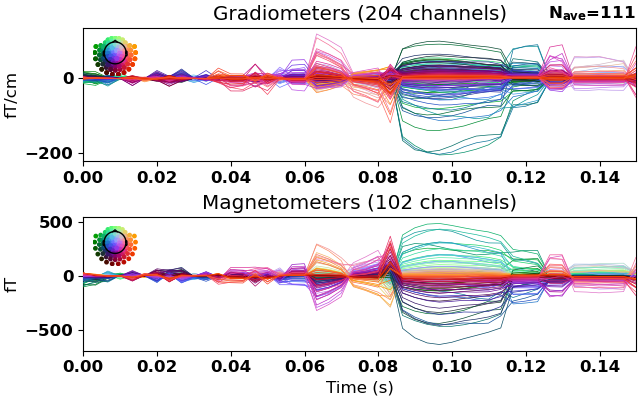

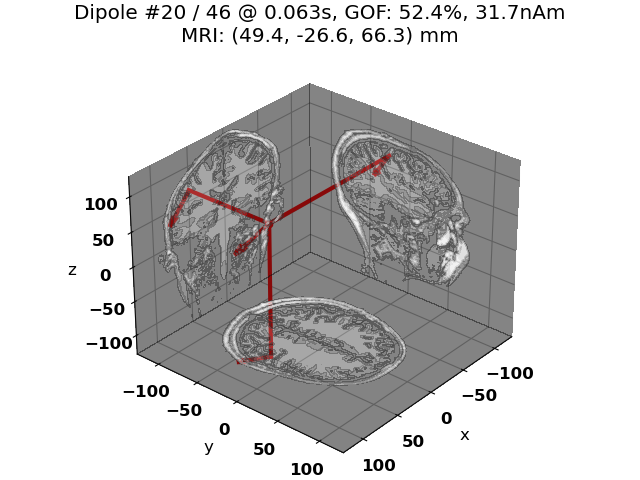

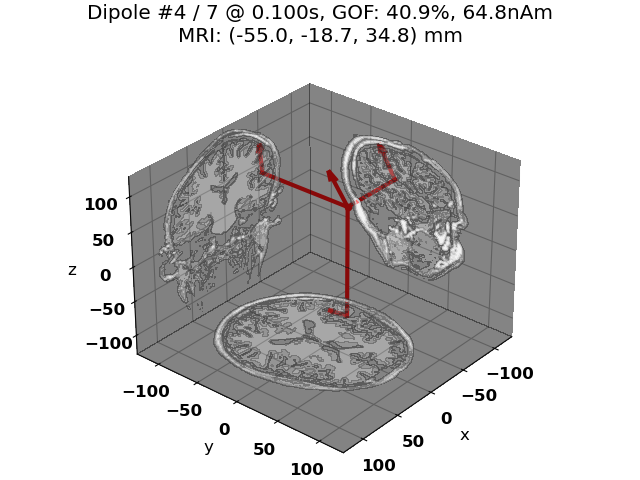

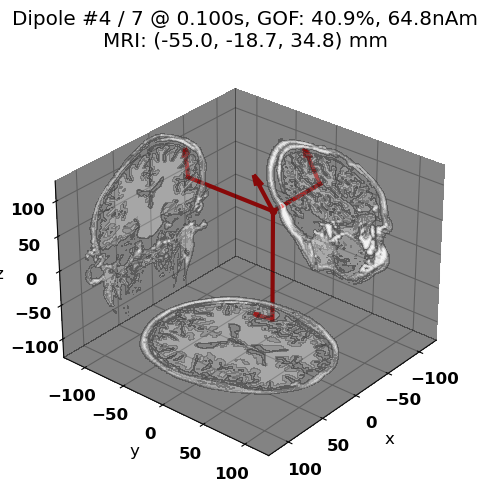

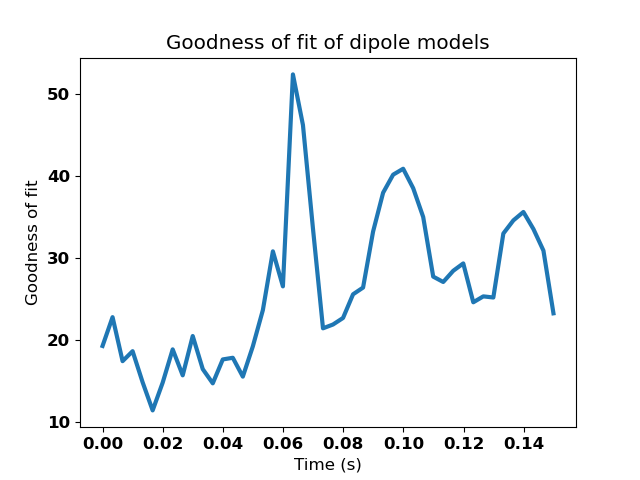

In [21]:
#%% sequential fit

dip_no2, residual_no2 = mne.dipole.fit_dipole(residual, noise_cov_somato,
                                      bem=bem_solution, trans=trans,
                                      n_jobs=-1)

modelled_response_no2 = residual.copy()
modelled_response_no2._data -= residual_no2.data

fig = plt.figure()
plt.plot(dip_no2.times, dip_no2.gof)
plt.title('Goodness of fit of dipole models')
plt.xlabel('Time (s)'); plt.ylabel('Goodness of fit') # 100 is max 0 is min

fig = plt.figure()
plt.plot(dip_no2.times, dip_no2.amplitude * 1e9)
plt.title('Amplitude of fitted dipoles')
plt.xlabel('Time (s)'); plt.ylabel('Current density (nAm)')
plt.show()

modelled_response_no2.plot()
dip_no2.plot_locations(trans=trans, subject=subject, subjects_dir=subjects_dir,
                   show_all=False) # show the dipole with the best fit

dip_no2_SII = dip_no2.copy()
dip_no2_SII.crop(0.090, 0.110)
dip_no2_SII.plot_locations(trans=trans, subject=subject, subjects_dir=subjects_dir,
                   show_all=False) # show the dipole with the best fit

Some experimental code inspired from: https://mne.tools/stable/auto_examples/inverse/multi_dipole_model.html#sphx-glr-auto-examples-inverse-multi-dipole-model-py, to extract time courses from epochs instead of evokeds, such that you could apply it in machine learning

Creating a forward model that is constrained to the position of the fitted dipole (based on the evokeds)

In [27]:
cropped_dip = dip.copy()
cropped_dip.crop(0.040, 0.040)


fwd, _ = mne.make_forward_dipole(dip, bem_solution, epochs_somato.info, trans=trans)


Positions (in meters) and orientations
46 sources
Source space          : <SourceSpaces: [<discrete, n_used=46>] head coords, ~5 KiB>
MRI -> head transform : /home/lau/mne_data/MNE-somato-data/derivatives/sub-01/somato-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 46 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.998557 0.034341 0.041291       0.91 mm
    -0.044994 0.954723 0.294074      23.61 mm
    -0.029322 -0.295507 0.954890      18.44 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.997640 -0.061033 -0.031446       3.42 mm
    0.063766 0.993449 0.094829       6.64 mm
    0.025452 -0.096610 0.994997      54.42 mm
    0.000000 0.000000 0.000000       1.00
MEG coil defini

Building the inverse operator, using the epochs

In [23]:

# Apply MNE inverse
inv = mne.minimum_norm.make_inverse_operator(epochs_somato.info, fwd, noise_cov_somato, fixed=True, depth=0)


Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 3.5e-12 (2.2e-16 eps * 306 dim * 52  max singular value)
    Estimated rank (mag + grad): 64
    MEG: rank 64 computed from 306 data channels with 0 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.49869
    scaling factor to adjust the trace = 6.59475e+17 (nchan = 306 nzero = 242)


Creating source time courses using MNE based on the constrained forward model (the forward model can be conceptualised as a very strong prior here)

In [24]:

cropped_epochs_somato = epochs_somato.copy()
cropped_epochs_somato.load_data()
cropped_epochs_somato.crop(0.000, 0.150)
stcs_40_ms = mne.minimum_norm.apply_inverse_epochs(cropped_epochs_somato, inv, lambda2=1, method="MNE")


Loading data for 111 events and 241 original time points ...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 64 (242 small eigenvalues omitted)
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 111
Processing epoch : 2 / 111
Processing epoch : 3 / 111
Processing epoch : 4 / 111
Processing epoch : 5 / 111
Processing epoch : 6 / 111
Processing epoch : 7 / 111
Processing epoch : 8 / 111
Processing epoch : 9 / 111
Processing epoch : 10 / 111
Processing epoch : 11 / 111
Processing epoch : 12 / 111
Processing epoch : 13 / 111
Processing epoch : 14 / 111
Processing epoch : 15 / 111
Processing epoch : 16 / 111
Processing epoch : 17 / 111
Processing epoch : 18 / 111
Processing epoch : 19 / 111
Processing epoch 

Creating a figure checking that the average (the thick black line) captures the original dipole fit at 40 ms

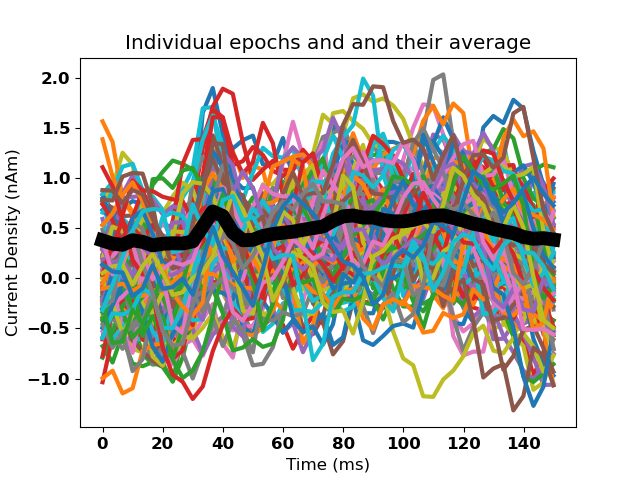

In [34]:

plt.figure()
avg_data = np.zeros(shape=(len(stcs_40_ms), len(cropped_epochs_somato.times)))
for stc_index, stc in enumerate(stcs_40_ms):
    this_data = np.mean(stc.data, axis=0) * 1e9
    plt.plot(stc.times * 1e3, this_data)
    avg_data[stc_index, :] = this_data
    
plt.plot(stc.times * 1e3, np.mean(np.abs(avg_data), axis=0) , 'k-', lw=10 )
plt.title('Individual epochs and and their average')
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (nAm)')
plt.show()
